# Rumour Analysis with COVID-19 Data

## Import necessary pack for analysing

In [2]:
import string
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from wordcloud import WordCloud
from  matplotlib.ticker import PercentFormatter

# Loading customization for plots
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Loading sklearn packages for modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from nltk.corpus import stopwords
stopword = stopwords.words('english')

## Load data

In [4]:
rumour_file = pd.read_csv("covid.rumour.csv")
non_rumour_file = pd.read_csv("covid.nonrumour.csv")

df = []
df.append(rumour_file)
df.append(non_rumour_file)
df_prediction = pd.concat(df)

In [5]:
rumour = rumour_file.values.tolist()
nonrumour = non_rumour_file.values.tolist()
prediction = []
for data in rumour:
    prediction.append(data)
for data in nonrumour:
    prediction.append(data)

In [6]:
df = df_prediction['tweet'].str.split("https://",1 , expand = True)
df_prediction['source'] = df[0]
df_prediction['replies'] = df[1]
df_prediction = df_prediction.astype({'replies':'str'})

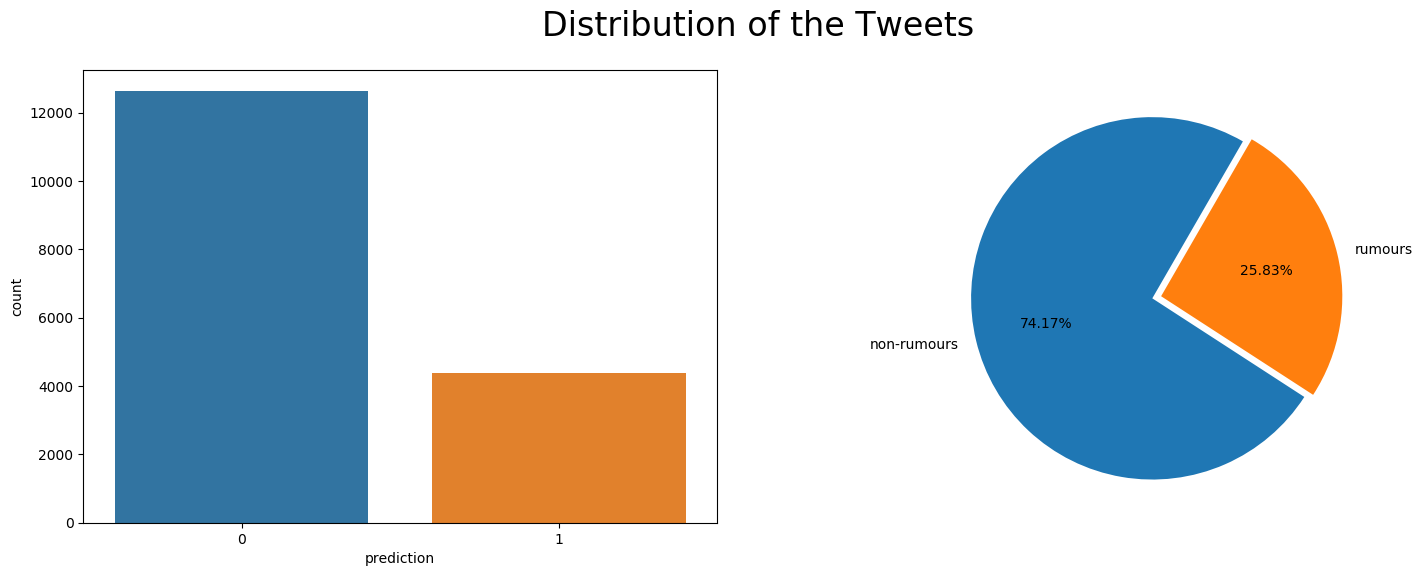

In [7]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
ax0 = sns.countplot(df_prediction['prediction'], ax = axes[0])
axes[1].pie(df_prediction['prediction'].value_counts(),
            labels=['non-rumours', 'rumours'],
            autopct='%1.2f%%',
            shadow=False,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

## 6.1 Most common words in tweet-chains

### Lemmatizing raw texts

In [8]:
nlp = spacy.load("en_core_web_sm")

In [9]:
def lemmatize(text):
    token = []
    result =''
    text = nlp(text)
    for t in text:
        if not t.is_stop and len(t)>2:  
            token.append(t.lemma_)
    result = ' '.join([i for i in token])
    return result

In [10]:
df_prediction['lemmatized'] = df_prediction['source'].apply(lambda x: lemmatize(x))

In [11]:
df_prediction['lemmatized_re'] = df_prediction['replies'].apply(lambda x: lemmatize(x))

In [12]:
lis = [
    df_prediction[df_prediction['prediction'] == 0]['lemmatized'],
    df_prediction[df_prediction['prediction'] == 1]['lemmatized']
]

In [13]:
lir = [
    df_prediction[df_prediction['prediction'] == 0]['lemmatized_re'],
    df_prediction[df_prediction['prediction'] == 1]['lemmatized_re']
]

### Getting most common unigram

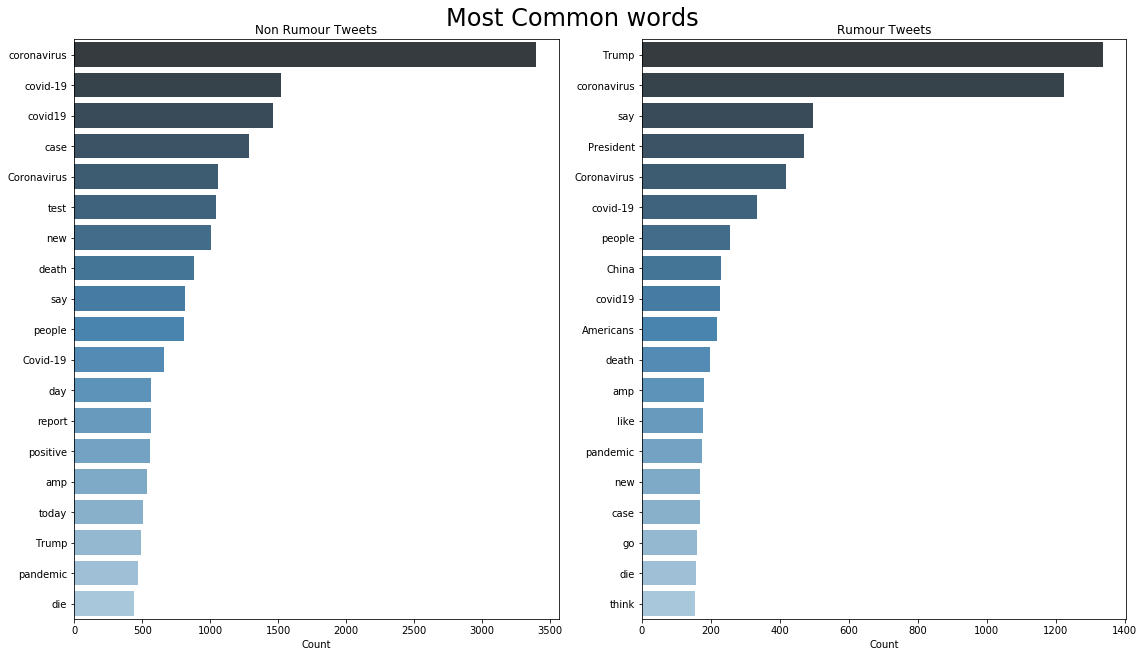

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
axes = axes.flatten()
most_word = []
raw_word = []
x_filters = []
y_filters = []

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    x_filter, y_filter = [], []
    for word, count in most:
        if (word not in stopword) and (word != '...'):
            x.append(word)
            y.append(count)
            if not word.startswith('@'):
                x_filter.append(word)
                y_filter.append(count)

    sns.barplot(x = y_filter[0:19], y = x_filter[0:19], palette='Blues_d', ax=j)
    most_word.append(most)
    raw_word.append(corpus)
    x_filters.append(x_filter)
    y_filters.append(y_filter)

axes[0].set_title('Non Rumour Tweets')
axes[1].set_title('Rumour Tweets')

axes[0].set_xlabel('Count')
#axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
#axes[1].set_ylabel('Word')

fig.suptitle('Most Common words', fontsize=24, va='baseline')
plt.tight_layout()

### Generating word cloud

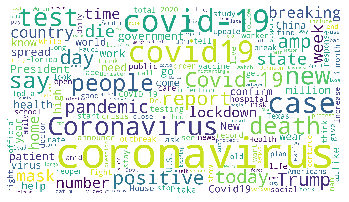

In [16]:
def show_cloud(wc):
    plt.figure()
    plt.imshow(wc)
    plt.axis("off")
wc = WordCloud(max_words = 200, width = 1920, height = 1080, background_color = "white", margin = 5)
d0 = dict(zip(x_filters[0],y_filters[0]))
wc.generate_from_frequencies(d0)
show_cloud(wc)
wc.to_file("cloud_nonrumours.png")

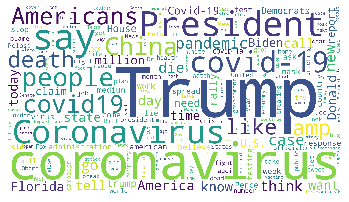

In [17]:
d1 = dict(zip(x_filters[1],y_filters[1]))

wc.generate_from_frequencies(d1)
show_cloud(wc)
wc.to_file("cloud_rumours.png")

### Calculating the ratio of rumours with certain word

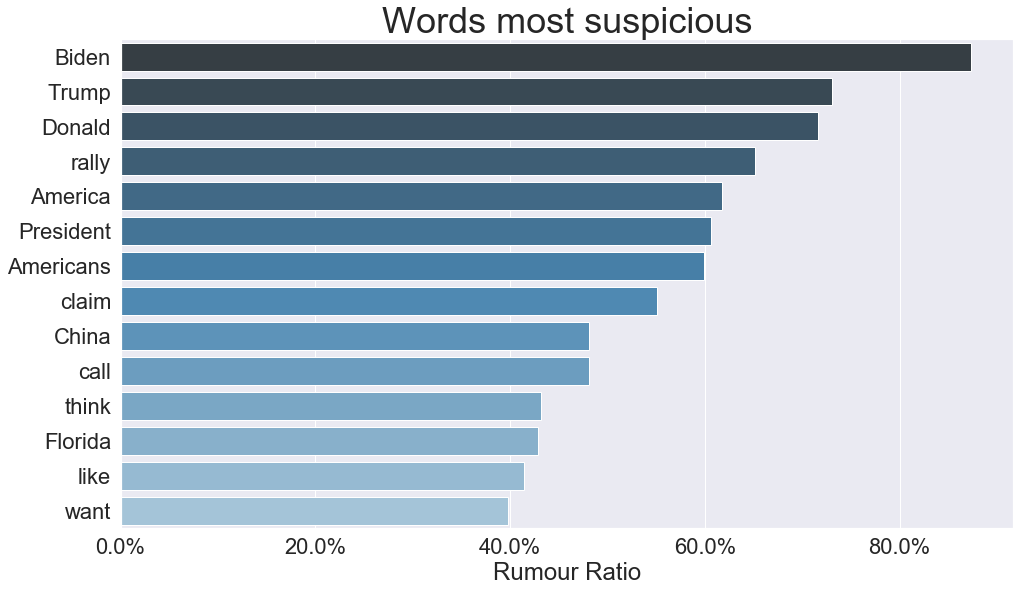

In [53]:
rumour_ratio = {}
for word in d1:
    if d1[word] > 100:
        rumour_frequency = d1[word]
        non_frequency = d0[word]
        ratio = rumour_frequency/(rumour_frequency + non_frequency)
        rumour_ratio[word] = ratio

top_ratio = sorted(rumour_ratio.items(), key = lambda x :-x[1])
x = []
y = []
x_filter = []
y_filter = []

for item in top_ratio:
    x.append(item[0])
    y.append(item[1])

for item in top_ratio:
    if not item[0].startswith('@'):
        x_filter.append(item[0])
        y_filter.append(item[1])


plt.figure(figsize = (16,9))
ax = sns.barplot(x = y_filter[0:14], y = x_filter[0:14], palette='Blues_d')
sns.set(font_scale = 2)
ax.xaxis.set_major_formatter(PercentFormatter(xmax = 1, decimals = 1))
ax.set_title('Words most suspicious', fontsize = 36)
ax.set_xlabel('Rumour Ratio')
plt.show()

### Getting most common bi-gram

In [50]:
def ngrams(n, title):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()

        def _get_top_ngram(corpus, n=None):
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            del_list = []
            del_count = 0
            for index, wf in enumerate(words_freq):
                bi_word = wf[0]
                bi_word = bi_word.split()
                if bi_word[1] == 'https':
                    del_list.append(index)
            for index in del_list:
                words_freq.pop(index-del_count)
                del_count = del_count + 1
            return words_freq

        top_n_bigrams = _get_top_ngram(i, n)[1:20]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='Blues_d', ax=j)
        sns.set(font_scale = 2)
        
        axes[0].set_title('Non Rumour Tweets')
        axes[1].set_title('Rumour Tweets')
        axes[0].set_xlabel('Count')
        #axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        #axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize = 36, va = 'baseline')
        plt.tight_layout()

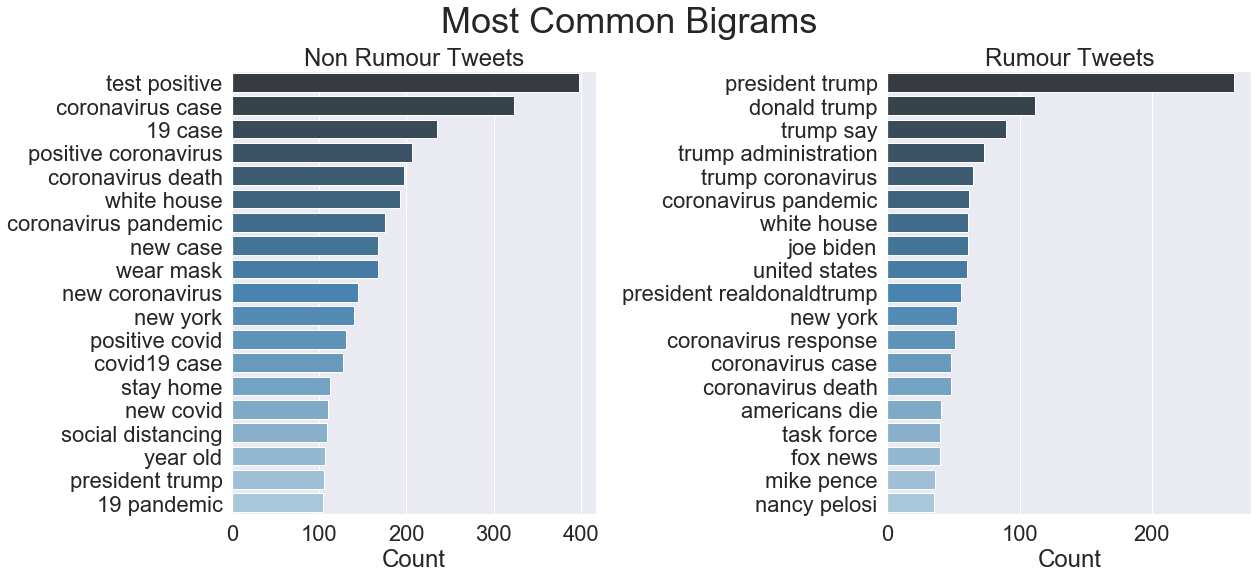

In [51]:
ngrams(2, 'Most Common Bigrams')

## 6.2 Topic further exploration

Using on-Negative Matrix Factorization (NMF) on TF-IDF matrix 

In [130]:
def display_topics(text, no_top_words, topic):
    
    """ A function for determining the topics present in our corpus with nmf """
    
    no_top_words = no_top_words
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.90, min_df=25, max_features=5000, use_idf=True)
    tfidf = tfidf_vectorizer.fit_transform(text)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    doc_term_matrix_tfidf = pd.DataFrame(
        tfidf.toarray(), columns=list(tfidf_feature_names))
    nmf = NMF(n_components=10, random_state=0,
              alpha=.1, init='nndsvd').fit(tfidf)
    print(topic)
    for topic_idx, topic in enumerate(nmf.components_):
        print('Topic %d:' % (topic_idx+1))
        print(' '.join([tfidf_feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [131]:
display_topics(lis[0], 7, 'Non-Rumour Topics\n')

Non-Rumour Topics

Topic 1:
covid 19 patient pandemic 2020 update die
Topic 2:
coronavirus outbreak pandemic china die spread lockdown
Topic 3:
covid19 update 2020 virus patient like thread
Topic 4:
test positive breaking player negative result member
Topic 5:
case new report confirm day total number
Topic 6:
people die know 000 million virus infect
Topic 7:
death 000 toll number report total 100
Topic 8:
say trump president house white dr fauci
Topic 9:
mask wear face public spread require social
Topic 10:
amp health pandemic home state government world


In [138]:
display_topics(lis[1], 10, 'Rumour Topics\n')

Rumour Topics

Topic 1:
coronavirus response bill spread pandemic crisis like chinese claim vaccine
Topic 2:
covid 19 spread rally call pandemic america think response kill
Topic 3:
realdonaldtrump amp american america lie work dead good virus let
Topic 4:
trump donald administration rally campaign response pandemic tulsa supporter breaking
Topic 5:
say think fauci secretary come year day dr need close
Topic 6:
covid19 like death time think know want amp hoax virus
Topic 7:
president house america white call pence vice united country mike
Topic 8:
people americans die 000 million go like american dead job
Topic 9:
china amp world lie virus chinese know go blame communist
Topic 10:
new death case florida report york state 000 day today


## 6.3 Popular hashtags

### Source hashtags

d:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


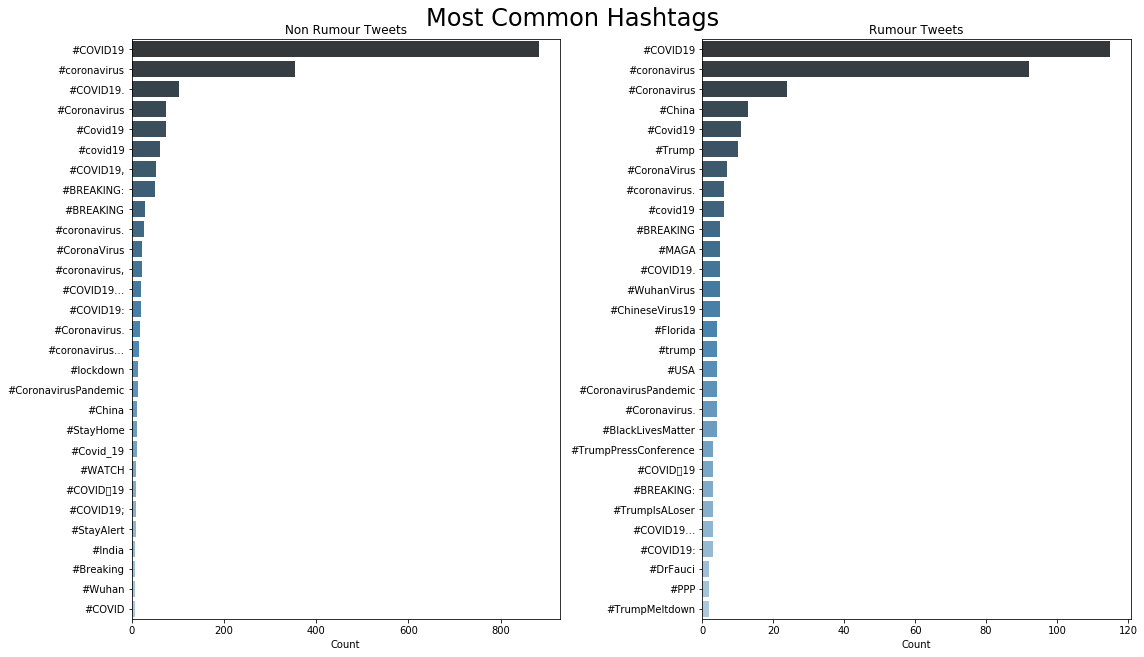

In [25]:
sou = [
    df_prediction[df_prediction['prediction'] == 0]['source'],
    df_prediction[df_prediction['prediction'] == 1]['source']
]

fig, axes = plt.subplots(1, 2, figsize=(16, 9))
axes = axes.flatten()
most_word = []
raw_word = []
x_filters = []
y_filters = []

for i, j in zip(sou, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    x_filter, y_filter = [], []
    for word, count in most:
        if (word not in stopword) and (word != '...'):
            x.append(word)
            y.append(count)
            if word.startswith('#'):
                x_filter.append(word)
                y_filter.append(count)

    sns.barplot(x = y_filter[0:29], y = x_filter[0:29], palette='Blues_d', ax=j)
    most_word.append(most)
    raw_word.append(corpus)
    x_filters.append(x_filter)
    y_filters.append(y_filter)

axes[0].set_title('Non Rumour Tweets')
axes[1].set_title('Rumour Tweets')

axes[0].set_xlabel('Count')
axes[1].set_xlabel('Count')

fig.suptitle('Most Common Hashtags', fontsize=24, va='baseline')
plt.tight_layout()

### Replies hashtags

d:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


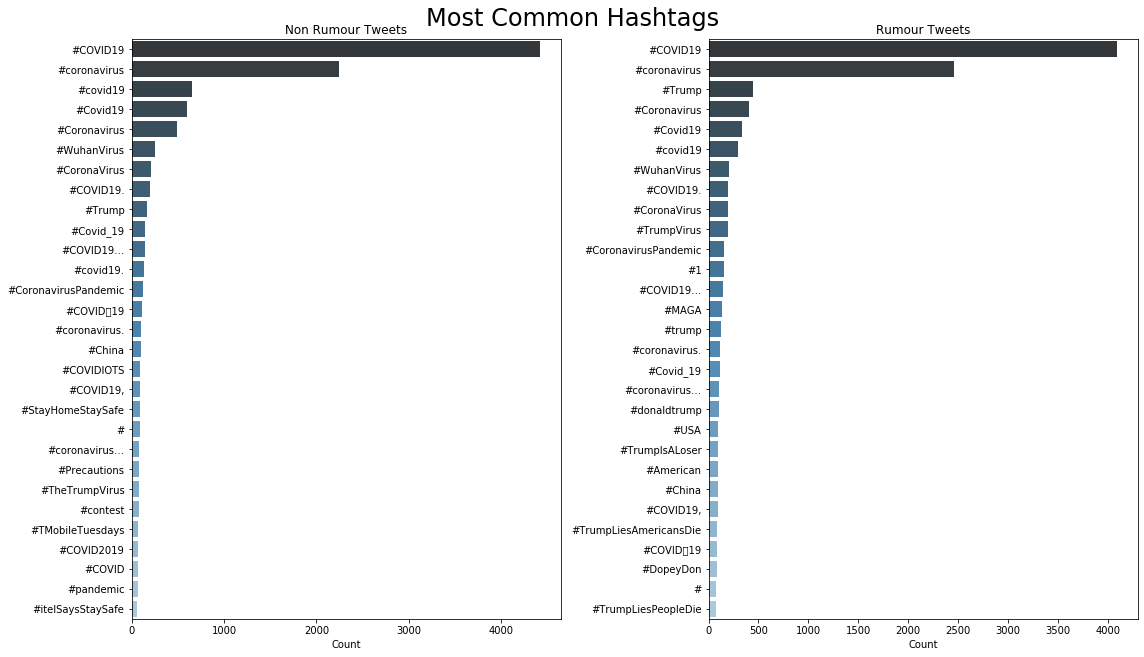

In [26]:
rep = [
    df_prediction[df_prediction['prediction'] == 0]['replies'],
    df_prediction[df_prediction['prediction'] == 1]['replies']
]

fig, axes = plt.subplots(1, 2, figsize=(16, 9))
axes = axes.flatten()
most_word = []
raw_word = []
x_filters = []
y_filters = []

for i, j in zip(rep, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    x_filter, y_filter = [], []
    for word, count in most:
        if (word not in stopword) and (word != '...'):
            x.append(word)
            y.append(count)
            if word.startswith('#'):
                x_filter.append(word)
                y_filter.append(count)

    sns.barplot(x = y_filter[0:29], y = x_filter[0:29], palette='Blues_d', ax=j)
    most_word.append(most)
    raw_word.append(corpus)
    x_filters.append(x_filter)
    y_filters.append(y_filter)

axes[0].set_title('Non Rumour Tweets')
axes[1].set_title('Rumour Tweets')

axes[0].set_xlabel('Count')
axes[1].set_xlabel('Count')

fig.suptitle('Most Common Hashtags', fontsize=24, va='baseline')
plt.tight_layout()

## 6.4 Sentiment Analysis

### Sentiment of source

In [27]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [32]:
def get_sentiment_scores(tweet_corpus):
    scores = {}
    scores['neg'] = 0
    scores['neu'] = 0
    scores['pos'] = 0
    scores['compound'] = 0

    for source_tweet in tweet_corpus:
        score = analyzer.polarity_scores(str(source_tweet))
        scores['neg'] += score['neg']
        scores['neu'] += score['neu']
        scores['pos'] += score['pos']
        scores['compound'] += score['compound']
    
    number_of_tweets = len(tweet_corpus)
    scores['neg'] = scores['neg']/number_of_tweets
    scores['neu'] = scores['neu']/number_of_tweets
    scores['pos'] = scores['pos']/number_of_tweets
    scores['compound'] = scores['compound']/number_of_tweets

    return scores

In [29]:
non_rumour_sentiment_scores_source = get_sentiment_scores(lis[0])
rumour_sentiment_scores_source = get_sentiment_scores(lis[1])

In [30]:
print('Sentiment of non-rumour tweets:')
print(non_rumour_sentiment_scores_source)
print('Sentiment of rumour tweets:')
print(rumour_sentiment_scores_source)

Sentiment of non-rumour tweets:
{'neg': 0.1233328053223502, 'neu': 0.7432580389672071, 'pos': 0.13064200855377767, 'compound': 0.001399231744020336}
Sentiment of rumour tweets:
{'neg': 0.17806505914467652, 'neu': 0.7064824840764331, 'pos': 0.11181323930846229, 'compound': -0.12268380345768862}


### Sentiment of replies

In [33]:
non_rumour_sentiment_scores_replies = get_sentiment_scores(lir[0])
rumour_sentiment_scores_replies = get_sentiment_scores(lir[1])

In [34]:
print('Sentiment of non-rumour tweets:')
print(non_rumour_sentiment_scores_replies)
print('Sentiment of rumour tweets:')
print(rumour_sentiment_scores_replies)

Sentiment of non-rumour tweets:
{'neg': 0.0999047204181844, 'neu': 0.7842547124980154, 'pos': 0.0908172817994612, 'compound': -0.0776656740060194}
Sentiment of rumour tweets:
{'neg': 0.1590450409463148, 'neu': 0.7324369881710671, 'pos': 0.09964149226569641, 'compound': -0.3649025705186528}
